In [1]:
# ===================================================================
# Notebook 1: Stacked Model (LSTM -> LightGBM -> Ridge Meta-Learner)
#
# Description:
# This notebook implements a three-stage forecasting model for the IHSG closing price.
# 1. An LSTM is trained on sequential data to capture temporal patterns.
# 2. A LightGBM model is trained on tabular data to capture feature interactions.
# 3. A simple Ridge regression model is trained as a meta-learner on the
#    predictions from the first two models to produce the final forecast.
#
# All major components are tuned using Optuna for optimal performance.
#
# WARNING: Full hyperparameter tuning on a CPU will be very time-consuming.
# ===================================================================

# ===================================================================
# 1. Setup and Imports
# ===================================================================
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import optuna

# Scikit-learn & LightGBM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
import lightgbm as lgb
import shap

# TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Statsmodels for stationarity test
from statsmodels.tsa.stattools import adfuller

# Configuration
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
tf.random.set_seed(42)
np.random.seed(42)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

# ===================================================================
# 2. Data Acquisition and Advanced Feature Engineering
# ===================================================================
print("Step 1: Downloading and preparing data with advanced features...")
variables = {
    "IHSG": "^JKSE", "S&P 500": "^GSPC", "Nasdaq": "^IXIC",
    "Crude Oil (WTI)": "CL=F", "Gold": "GC=F", "USD/IDR": "IDR=X",
    "DAX": "^GDAXI", "Crude Oil (Brent)": "BZ=F", "Copper": "HG=F"
}
# Download OHLC data instead of just 'Close'
data_ohlc = yf.download(list(variables.values()), start="2010-01-01", end=datetime.now().strftime('%Y-%m-%d'))
data = data_ohlc['Close'].copy()
data.rename(columns={v: k for k, v in variables.items()}, inplace=True)
data = data.ffill().bfill()

# --- Advanced Feature Engineering ---
# Technical Indicators for IHSG
data['MA10'] = data['IHSG'].rolling(window=10).mean()
data['MA50'] = data['IHSG'].rolling(window=50).mean()
delta = data['IHSG'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI14'] = 100 - (100 / (1 + rs))

# Volatility Features
# Bollinger Bands
data['BB_Mid'] = data['IHSG'].rolling(window=20).mean()
data['BB_Std'] = data['IHSG'].rolling(window=20).std()
data['BB_Upper'] = data['BB_Mid'] + (data['BB_Std'] * 2)
data['BB_Lower'] = data['BB_Mid'] - (data['BB_Std'] * 2)

# Average True Range (ATR)
high_low = data_ohlc['High']['^JKSE'] - data_ohlc['Low']['^JKSE']
high_close = np.abs(data_ohlc['High']['^JKSE'] - data['IHSG'].shift())
low_close = np.abs(data_ohlc['Low']['^JKSE'] - data['IHSG'].shift())
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
data['ATR'] = tr.rolling(window=14).mean()

# Momentum Features (Stochastic Oscillator)
low_14 = data_ohlc['Low']['^JKSE'].rolling(window=14).min()
high_14 = data_ohlc['High']['^JKSE'].rolling(window=14).max()
data['%K'] = 100 * ((data['IHSG'] - low_14) / (high_14 - low_14))
data['%D'] = data['%K'].rolling(window=3).mean()

# Global Market Features
for col in variables.keys():
    if col != 'IHSG':
        data[f'{col}_pct_change_1d'] = data[col].pct_change(1)
        data[f'{col}_pct_change_5d'] = data[col].pct_change(5)

# Time-based features
data['DayOfWeek'] = data.index.dayofweek
data['Month'] = data.index.month

data.dropna(inplace=True)
print(f"Data shape after feature engineering: {data.shape}")

# ===================================================================
# 2.5. Stationarity Analysis (ADF Test)
# ===================================================================
print("\nStep 2.5: Performing Stationarity Analysis...")

def perform_adf_test(series, series_name):
    """Performs and prints the results of the Augmented Dickey-Fuller test."""
    result = adfuller(series)
    print(f'--- ADF Test Results for {series_name} ---')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')

    if result[1] <= 0.05:
        print("Conclusion: Reject the null hypothesis. Data is likely stationary.")
    else:
        print("Conclusion: Fail to reject the null hypothesis. Data is likely non-stationary.")
    print("-" * 40)

# Test on the original price series
perform_adf_test(data['IHSG'], "IHSG Price Series")

# Test on the differenced (return) series
perform_adf_test(data['IHSG'].pct_change(1).dropna(), "IHSG Return Series")


# ===================================================================
# 3. Data Preparation: Predicting Returns
# ===================================================================
print("\nStep 3: Preparing data for modeling (predicting returns)...")
# --- IMPROVEMENT: Predict percentage returns for stationarity ---
data['Target'] = data['IHSG'].pct_change(1).shift(-1)
data.dropna(inplace=True)

# --- FIX: Remove data leakage by excluding the current day's price from features ---
features = [col for col in data.columns if col not in ['Target', 'IHSG']]
X = data[features]
y = data['Target']

# Time-based split
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Scale features
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale target (returns)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")


/home/rangga/metopen/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-09 12:54:56.631268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752040496.653564  217389 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752040496.659679  217389 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752040496.679568  217389 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0

Step 1: Downloading and preparing data with advanced features...


[*********************100%***********************]  9 of 9 completed


Data shape after feature engineering: (1762, 37)

Step 2.5: Performing Stationarity Analysis...
--- ADF Test Results for IHSG Price Series ---
ADF Statistic: -1.9533
p-value: 0.3074
Critical Values:
	1%: -3.4341
	5%: -2.8632
	10%: -2.5676
Conclusion: Fail to reject the null hypothesis. Data is likely non-stationary.
----------------------------------------
--- ADF Test Results for IHSG Return Series ---
ADF Statistic: -21.6312
p-value: 0.0000
Critical Values:
	1%: -3.4341
	5%: -2.8632
	10%: -2.5676
Conclusion: Reject the null hypothesis. Data is likely stationary.
----------------------------------------

Step 3: Preparing data for modeling (predicting returns)...
Training set shape: X=(1408, 36), y=(1408,)
Test set shape: X=(353, 36), y=(353,)


In [2]:
# ===================================================================
# 4. Stage 1: LSTM Model Training and Tuning
# ===================================================================
print("Step 3: Tuning and Training LSTM model...")
TIME_STEPS = 60
def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled)
def objective_lstm(trial):
    model = Sequential()
    model.add(LSTM(units=trial.suggest_int('units_1', 32, 128, step=16), return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(Dropout(trial.suggest_float('dropout_1', 0.1, 0.5)))
    model.add(LSTM(units=trial.suggest_int('units_2', 16, 64, step=16), return_sequences=False))
    model.add(Dropout(trial.suggest_float('dropout_2', 0.1, 0.5)))
    if trial.suggest_categorical('n_dense_layers', [0, 1]) == 1:
        model.add(Dense(units=trial.suggest_int('dense_units', 16, 64, step=16), activation='relu'))
    model.add(Dense(1))
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=batch_size, validation_split=0.1,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)], verbose=1)
    return min(history.history['val_loss'])
study_lstm = optuna.create_study(direction='minimize')
study_lstm.optimize(objective_lstm, n_trials=15)
best_params_lstm = study_lstm.best_params
final_lstm_model = Sequential()
final_lstm_model.add(LSTM(units=best_params_lstm['units_1'], return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
final_lstm_model.add(Dropout(best_params_lstm['dropout_1']))
final_lstm_model.add(LSTM(units=best_params_lstm['units_2'], return_sequences=False))
final_lstm_model.add(Dropout(best_params_lstm['dropout_2']))
if best_params_lstm['n_dense_layers'] == 1:
    final_lstm_model.add(Dense(units=best_params_lstm['dense_units'], activation='relu'))
final_lstm_model.add(Dense(1))
final_lstm_model.compile(optimizer=Adam(learning_rate=best_params_lstm['learning_rate']), loss='mean_squared_error')
final_lstm_model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=best_params_lstm['batch_size'], validation_split=0.1,
                     callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)], verbose=1)
lstm_train_pred_scaled = final_lstm_model.predict(X_train_seq)
lstm_test_pred_scaled = final_lstm_model.predict(X_test_seq)
print("LSTM model trained.")

Step 3: Tuning and Training LSTM model...
Epoch 1/50


2025-07-09 12:54:59.573519: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.0531 - val_loss: 6.1679e-04
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0041 - val_loss: 7.0641e-04
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0032 - val_loss: 5.6307e-04
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0027 - val_loss: 6.9654e-04
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0026 - val_loss: 8.6951e-04
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0025 - val_loss: 9.8587e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0026 - val_loss: 8.4888e-04
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0023 - val_loss: 7.7385e-04
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0021 - val_loss: 9.0812e-04
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━

In [3]:
# ===================================================================
# 5. Stage 2: LightGBM Model Training and Tuning
# ===================================================================
print("Step 4: Tuning and Training LightGBM model...")
X_train_tabular = X_train_scaled[TIME_STEPS:]
X_test_tabular = X_test_scaled[TIME_STEPS:]
def objective_lgbm(trial):
    params = {
        'objective': 'regression_l1', 'metric': 'mae', 'verbosity': -1,
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000), 'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100), 'max_depth': trial.suggest_int('max_depth', 5, 20),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0), 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True), 'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train_tabular, y_train_seq.ravel())
    preds = model.predict(X_test_tabular)
    return mean_squared_error(y_test_seq, preds)
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=20)
best_params_lgbm = study_lgbm.best_params
final_lgbm_model = lgb.LGBMRegressor(**best_params_lgbm)
final_lgbm_model.fit(X_train_tabular, y_train_seq.ravel())
lgbm_train_pred_scaled = final_lgbm_model.predict(X_train_tabular).reshape(-1, 1)
lgbm_test_pred_scaled = final_lgbm_model.predict(X_test_tabular).reshape(-1, 1)
print("LightGBM model trained.")

Step 4: Tuning and Training LightGBM model...
LightGBM model trained.


In [4]:
# ===================================================================
# 6. Stage 3: Ridge Meta-Learner
# ===================================================================
print("Step 5: Training Ridge meta-learner...")
meta_features_train = np.hstack([lstm_train_pred_scaled, lgbm_train_pred_scaled])
meta_features_test = np.hstack([lstm_test_pred_scaled, lgbm_test_pred_scaled])
meta_model = Ridge()
meta_model.fit(meta_features_train, y_train_seq)
final_predictions_scaled = meta_model.predict(meta_features_test)

Step 5: Training Ridge meta-learner...



Step 7: Evaluating final model and generating plots...

--- Performance on Returns ---
RMSE (returns): 0.010688
MAE (returns):  0.007359

--- Performance on Reconstructed Price ---
RMSE (price): 72.15
MAE (price):  50.40
R² (price):   0.9536
SMAPE (price): 0.72%


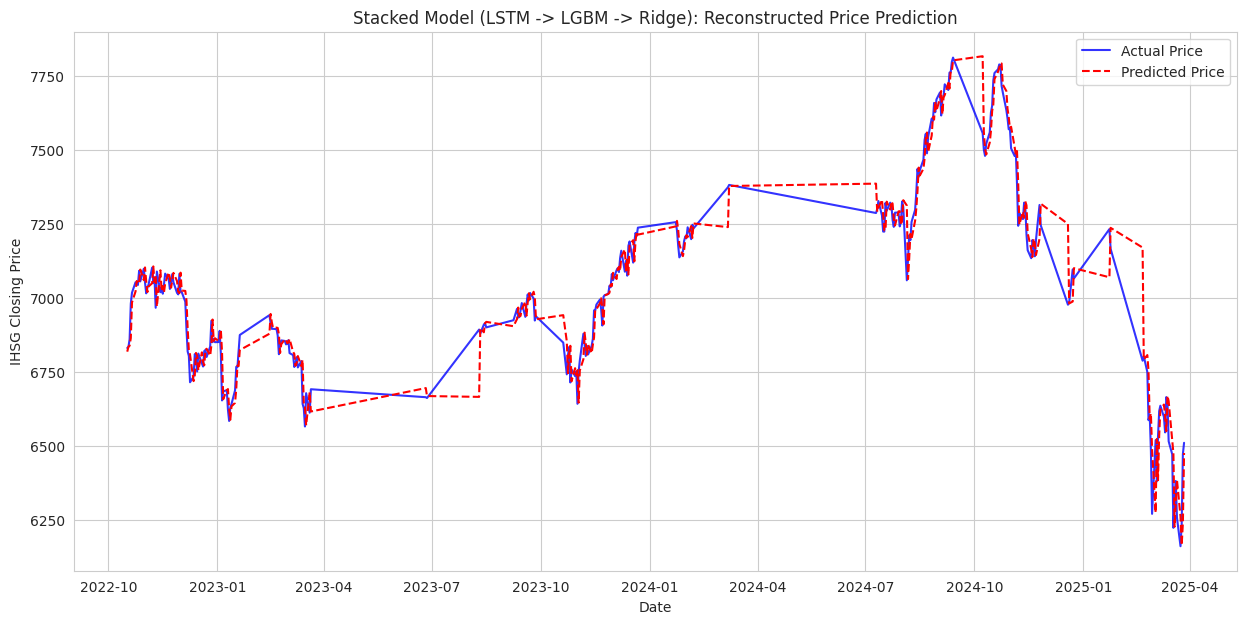


Generating SHAP plots for the LightGBM component...


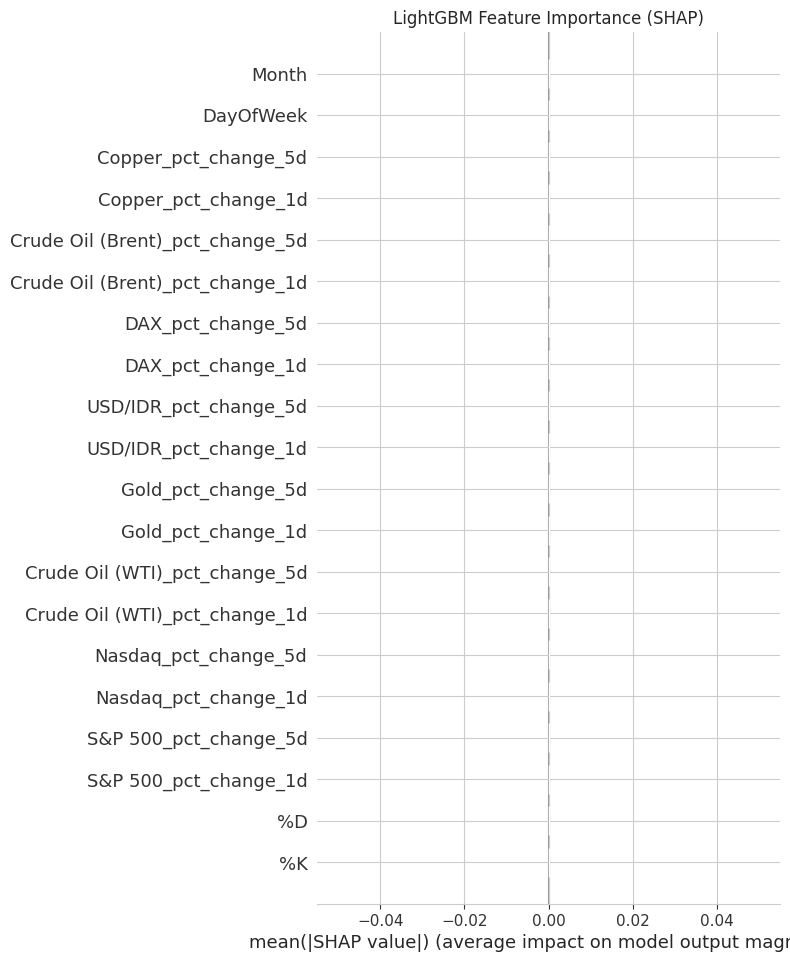

In [5]:
# ===================================================================
# 7. Evaluation and Interpretability
# ===================================================================
print("\nStep 7: Evaluating final model and generating plots...")

# --- Inverse transform predicted returns ---
final_predicted_returns = scaler_y.inverse_transform(final_predictions_scaled.reshape(-1, 1)).flatten()
y_test_returns_actual = y_test.iloc[TIME_STEPS:].values

# --- Reconstruct price prediction from returns ---
last_known_prices = data['IHSG'].iloc[train_size + TIME_STEPS -1:-1].values
reconstructed_price_pred = last_known_prices * (1 + final_predicted_returns)
y_test_price_actual = data['IHSG'].iloc[train_size + TIME_STEPS:].values

# --- Metrics ---
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

print("\n--- Performance on Returns ---")
print(f"RMSE (returns): {np.sqrt(mean_squared_error(y_test_returns_actual, final_predicted_returns)):.6f}")
print(f"MAE (returns):  {mean_absolute_error(y_test_returns_actual, final_predicted_returns):.6f}")

print("\n--- Performance on Reconstructed Price ---")
print(f"RMSE (price): {np.sqrt(mean_squared_error(y_test_price_actual, reconstructed_price_pred)):.2f}")
print(f"MAE (price):  {mean_absolute_error(y_test_price_actual, reconstructed_price_pred):.2f}")
print(f"R² (price):   {r2_score(y_test_price_actual, reconstructed_price_pred):.4f}")
print(f"SMAPE (price): {smape(y_test_price_actual, reconstructed_price_pred):.2f}%")

# --- Plotting ---
plt.figure(figsize=(15, 7))
plt.plot(y_test.index[TIME_STEPS:], y_test_price_actual, label='Actual Price', color='blue', alpha=0.8)
plt.plot(y_test.index[TIME_STEPS:], reconstructed_price_pred, label='Predicted Price', color='red', linestyle='--')
plt.title('Stacked Model (LSTM -> LGBM -> Ridge): Reconstructed Price Prediction')
plt.xlabel('Date')
plt.ylabel('IHSG Closing Price')
plt.legend()
plt.show()

# --- SHAP Interpretability on the LightGBM model ---
print("\nGenerating SHAP plots for the LightGBM component...")
explainer = shap.TreeExplainer(final_lgbm_model)
shap_values = explainer.shap_values(X_test_tabular)
shap.summary_plot(shap_values, pd.DataFrame(X_test_tabular, columns=features), plot_type="bar", show=False)
plt.title("LightGBM Feature Importance (SHAP)")
plt.show()
